In [6]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

from src.pupil import ScalarPolarPupil
from src.propagator import ScalarPolarPropagator
from src.testers import ScalarPolarTester, polar_gaussian

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


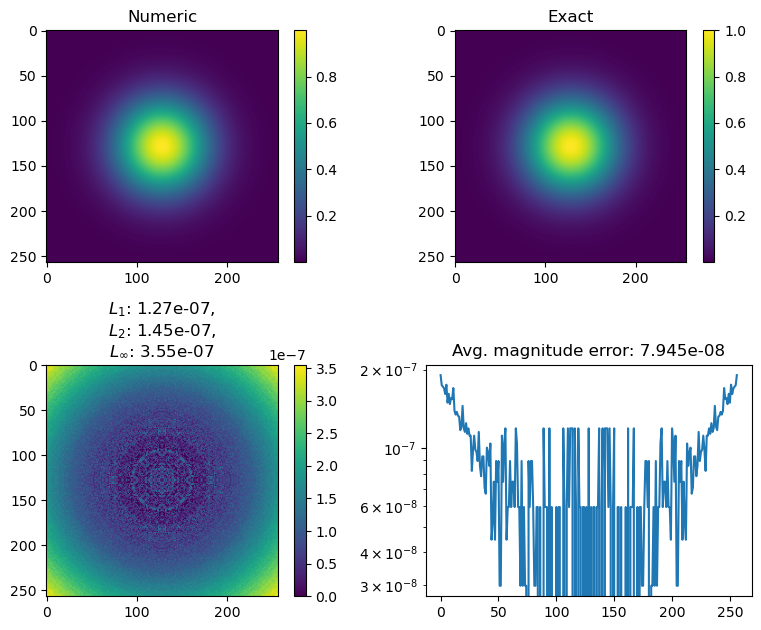

In [7]:
Ep_ref, Ep_num = ScalarPolarTester.eval_error(64*4 + 1, polar_gaussian, plot=True)[1:]
# PolarTester.plot_convergence(polar_gaussian)

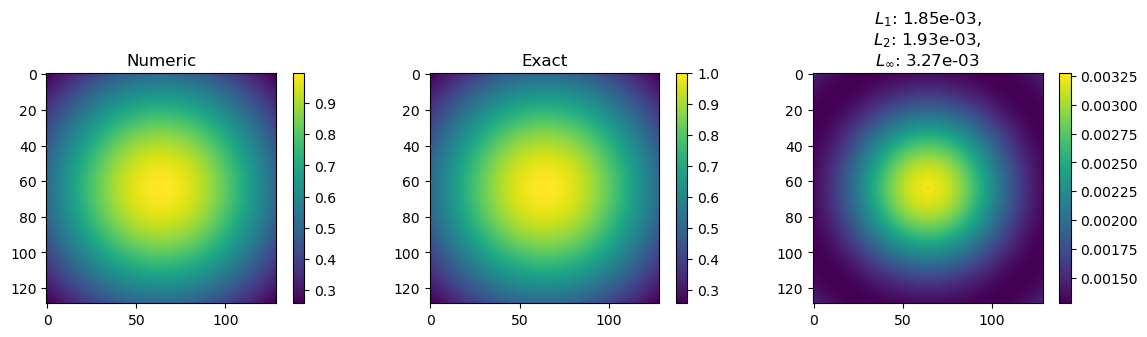

In [8]:
pupil = ScalarPolarPupil(32*4+1)
prop  = ScalarPolarPropagator(pupil=pupil, 
             n_pix_psf=pupil.n_pix_pupil,
             n_defocus=1, 
             defocus_min=0,
             defocus_max=0, 
             fov=1e4,
             envelope=None, 
             apod_factor=False, 
             gibson_lanni=False)

# field, field_ref = prop.test_compute_field_tc1()
# field, field_ref = prop.compute_focus_field_tc2()

from torch.special import bessel_j0, bessel_j1

theta_p = prop.thetas[-1] * 0.1
# STEP (???) O(h): discontinuity?
# far_fields = 2.0 * torch.cos(prop.thetas) / torch.sin(theta_p) ** 2 * (prop.k * (torch.sin(theta_p) - torch.sin(prop.thetas)) > 0.0)
# sol_arg = prop.k * prop.rs * torch.sin(theta_p)
# field_ref = 2.0 * torch.where(sol_arg > 1e-6, bessel_j1(sol_arg) / sol_arg, 0.5 - sol_arg ** 2 / 16)
# field_ref = field_ref[prop.rr_indices]
# e_star = False

# # EXP
# far_fields = torch.cos(prop.thetas) / torch.sin(theta_p) ** 2 * torch.exp( - torch.sin(prop.thetas) / torch.sin(theta_p))
# field_ref = (1.0 + (prop.k * prop.rs * torch.sin(theta_p)) ** 2) ** -1.5
# field_ref = field_ref[prop.rr_indices]
# e_star = False

# # GAUSSIAN, O(h**4)
# far_fields = 2.0 * torch.cos(prop.thetas) / torch.sin(theta_p) ** 2 * torch.exp( - (torch.sin(prop.thetas) / torch.sin(theta_p)) ** 2)
# field_ref = torch.exp(- (0.5 * prop.k * prop.rs * torch.sin(theta_p)) ** 2)
# field_ref = field_ref[prop.rr_indices]
# e_star = False

# LOG-STEP,  O(h**2): discontinuity?
far_fields = 4.0 * torch.cos(prop.thetas) / torch.sin(theta_p) ** 2 * \
             (prop.k * (torch.sin(theta_p) - torch.sin(prop.thetas)) > 0.0) * \
             torch.where(prop.thetas != 0.0,
                         torch.log(torch.sin(theta_p) / torch.sin(prop.thetas)) * torch.sin(prop.thetas),
                         0.0)
sol_arg = prop.k * prop.rs * torch.sin(theta_p)
field_ref = 4.0 * torch.where(sol_arg > 1e-6, 
                (1.0 - bessel_j0(sol_arg)) / sol_arg ** 2, 
                0.25 - sol_arg ** 2 / 64)
field_ref = field_ref[prop.rr_indices]
e_star = True


field = prop._compute_PSF_for_far_field(far_fields, e_star).squeeze()

plt.figure(figsize=(12,3.2))
plt.subplot(131)
plt.imshow(field.abs())
plt.title("Numeric")
plt.colorbar()
plt.subplot(132)
plt.title("Exact")
plt.imshow(field_ref.abs())
plt.colorbar()
plt.subplot(133)
err = (field_ref - field).abs()
plt.title(f"$L_1$: {err.mean().item():.2e},\n$L_2$: {(err.norm() / len(err)).item():.2e},\n$L_\infty$: {err.max().item():.2e}")
plt.imshow(err)
plt.colorbar()
plt.tight_layout()

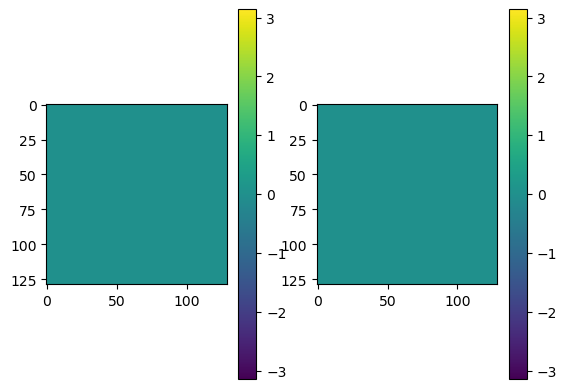

In [10]:
plt.subplot(121)
plt.imshow(field.angle(), vmin=-torch.pi, vmax=torch.pi)
plt.colorbar()

plt.subplot(122)
plt.imshow(field_ref.angle(), vmin=-torch.pi, vmax=torch.pi)
plt.colorbar()

Text(0.5, 1.0, 'Phase error: 0.000 rad')

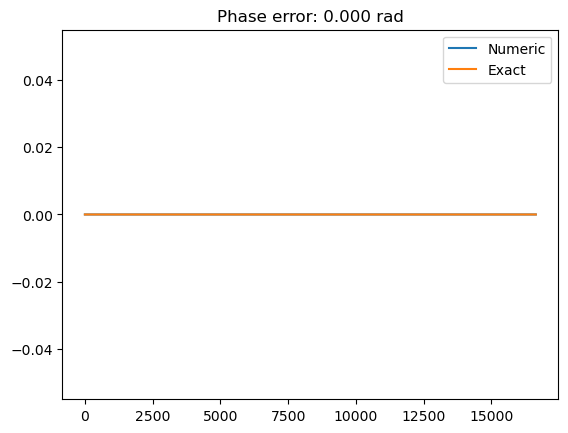

In [11]:
plt.plot(field.ravel().angle().sort()[0], label="Numeric")
plt.plot(field_ref.ravel().angle().sort()[0], label="Exact")
plt.legend()

plt.title(f"Phase error: {(field.angle() - field_ref.angle()).mean().item():.3f} rad")

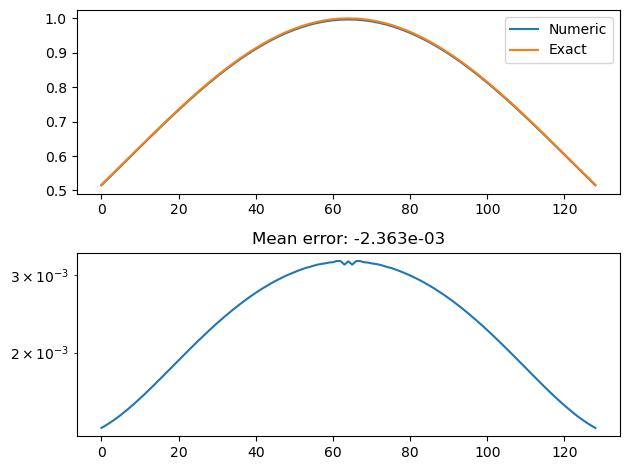

In [12]:
N = pupil.n_pix_pupil
plt.figure()
plt.subplot(211)
y = field[N//2].abs()
y_ref = field_ref[N//2].abs()
plt.plot(y, label="Numeric")
plt.plot(y_ref, label="Exact")
plt.legend()
plt.subplot(212)
plt.semilogy((y - y_ref).abs())

plt.title(f"Mean error: {(y - y_ref).mean().item():.3e}")

plt.tight_layout()